## Depression Identification Simulation

Note: The features are generated using PCA.ipynb.

In [1]:
import pandas as pd
import numpy as np

df_feats = pd.read_csv('reduced_data.csv')
df_labels = pd.read_csv('disorders.csv')['Depressed']

## 1. State assumptions about your data

- X are i.i.d. random variables.
- y ~ Bern(p)

## 2. Formally define classification problem

Feature matrix X: R<sup>n x m</sup>

Each sample X<sub>i</sub> ∈ R<sup>m</sup>, i ∈ [1, n]

Label y<sub>i</sub> ∈ {0, 1}, i ∈ [1, n]

g(X) → y

G := { g: R → {0, 1} }

Goal: g<sup>*</sup> = argmin<sub>g ∈ G</sub> E[L(g(X), y)], where L denotes loss function.


The loss function L differs for different classifiers and is speficied in the classfication context below:

- Multinomial Naive Bayes: negative joint likelihood

    - L = -log p(X, y)
    
    
- Logistic Regression:  logistic loss (cross-entropy loss)

    - L = -log P(y|g(X)) = -(y · log(g(X)) + (1 - y) · log(1 - g(X))


- K Nearest Neighbors

    - L = ∑<sub>i</sub> D(X<sub>i</sub>|y<sub>i</sub>=1, X|y=1) + ∑<sub>i</sub> D(X<sub>i</sub>|y<sub>i</sub>=0, X|y=0)
    
    - D(a, b) = (a - b)<sup>2</sup>


- Support Vector Machine: squared hinge loss

    - L = (max{0, 1 − y · g(x)})<sup>2</sup>


- Random Forest

    - L = ∑<sub>i</sub> (g(X<sub>i</sub>) - y<sub>i</sub>)<sup>2</sup>
    

## 3. Provide algorithm for solving problem (including choosing hyperparameters as appropriate)

- Multinomial Naive Bayes

    - alpha: default =1.0 (Laplace smoothing parameter)
    
    - fit_prior: default = True (learn class prior probabilities)
    
    
- Logistic Regression

    - penalty = 'l1' (l1 norm for penalization)


- K Nearest Neighbors

    - n_neighbors = 10


- Support Vector Machine (Linear Kernel)
    
    - C: default = 1.0 (penalty parameter of the error term)
    

- Random Forest
    
    - n_estimators = 20 (number of trees)
    
    - criterion: default = 'gini'

### Simulation Setup

In [2]:
np.random.seed(12345678) # for reproducibility, set random seed
r = 20  # define number of rois
N = 100 # number of samples at each iteration
p0 = 0.10
p1 = 0.15

# define number of subjects per class
S = np.array((8, 16, 20, 32, 40, 64, 80, 100, 120, 200, 320, 400, 800, 1000))

### Training & Test Utilities

In [3]:
# Train the given classifier
def train_clf(clf, train_feats, train_labels):
    # Supervised training
    clf.fit(train_feats, train_labels)
    
# Test the given classifier anc calculate accuracy
def test_clf(clf, test_feats, test_labels):
    # Predict using test set
    predicted = clf.predict(test_feats)
    # Compute accuracy
    acc = np.mean(predicted == test_labels)
    return predicted, acc

# Compute accuracy of a model trained with a specific number of samples
def compute_acc(clf, n):
    train_clf(clf, train_X[:n], train_y[:n])
    predict_y, acc = test_clf(clf, test_X, test_y)
    return acc

## 4 & 5. Sample data from a simulation setting & Compute Accuracy 

In [4]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

[acc_NB, acc_LG, acc_KNN, acc_SVM, acc_RF] = [[]  for i in xrange(5)] 

for idx1, s in enumerate(S):
    s0=s/2
    s1=s/2

    g0 = 1 * (np.random.rand( r, r, s0) > 1-p0)
    g1 = 1 * (np.random.rand( r, r, s1) > 1-p1)
    mbar0 = 1.0*np.sum(g0, axis=(0,1))
    mbar1 = 1.0*np.sum(g1, axis=(0,1))

    X = np.array((np.append(mbar0, mbar1), np.append(mbar0/( r**2), mbar1/( r**2 )))).T
    y = np.append(np.zeros(s0), np.ones(s1))
    
    # Split the simulated data into training set and test set
    # Randomly sample 20% data as the test set
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
    max_n = len(train_X)
    
    [acc_NB, acc_LG, acc_KNN, acc_SVM, acc_RF] = [[]  for i in xrange(5)] 

    for n in xrange(100, max_n, 100):
        # Multinomial Naive Bayes
        multiNB = MultinomialNB()
        acc_NB.append(compute_acc(multiNB, n))

        # Logistic Regression
        lg = LogisticRegression(penalty='l1')
        acc_LG.append(compute_acc(lg, n))

        # K Nearest Neighbors
        knn = KNeighborsClassifier(n_neighbors=10)
        acc_KNN.append(compute_acc(knn, n))

        # Support Vector Machine
        svc = LinearSVC()
        acc_SVM.append(compute_acc(svc, n)) 

        # Random Forest
        rf = RandomForestClassifier(n_estimators=20) 
        acc_RF.append(compute_acc(rf, n))

## 6. Plot accuracy vs. sample size in simulation

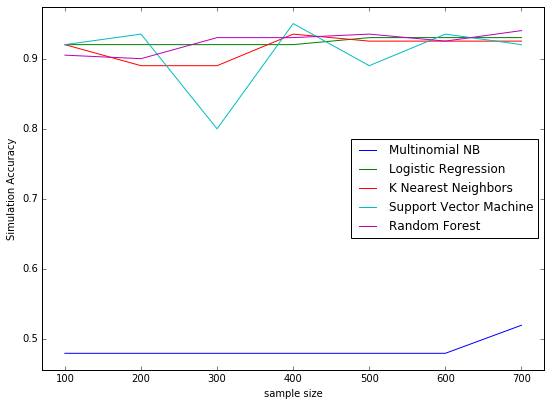

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

sizes = range(100, max_n, 100)

fig = plt.figure(1)
fig.set_size_inches(9, 6.5)

plt.plot(sizes, acc_NB, label='Multinomial NB')
plt.plot(sizes, acc_LG, label='Logistic Regression')
plt.plot(sizes, acc_KNN, label='K Nearest Neighbors')
plt.plot(sizes, acc_SVM, label='Support Vector Machine')
plt.plot(sizes, acc_RF, label='Random Forest')

plt.legend(loc='best')
plt.xlabel('sample size')
plt.ylabel('Simulation Accuracy')

## 7. Apply method directly on real data

In [6]:
real_y = df_labels.get_values()
real_X = df_feats.get_values()

def clean_negs(X):
    # Get indices of columns that contain negative values
    neg_col_inds = np.unique(np.where(X<0)[1])
    # Subtract minimum negative for each column
    for neg_i in neg_col_inds:
        neg_col = X[:, neg_i]
        min_neg = np.min(neg_col)
        new_col = [c - min_neg for c in neg_col] 
        X[:, neg_i] = new_col
    return X

real_X = clean_negs(real_X)

In [7]:
'''
Data Preparation
'''
from sklearn.cross_validation import train_test_split

# Split the simulated data into training set and test set
# Randomly sample 20% data as the test set
train_X, test_X, train_y, test_y = train_test_split(real_X, real_y, test_size=0.2, random_state=42)

print 'Training set size is', train_X.shape
print 'Testing set size is', test_X.shape

max_n = len(train_X)

Training set size is (2236, 27)
Testing set size is (560, 27)


In [8]:
# Multinomial Naive Bayes
multiNB = MultinomialNB()
train_clf(multiNB, train_X, train_y)
predict_y, acc_nb = test_clf(multiNB, test_X, test_y)

# Logistic Regression
lg = LogisticRegression(penalty='l1')
train_clf(lg, train_X, train_y)
predict_y, acc_lg = test_clf(lg, test_X, test_y)

# K Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=10)
train_clf(knn, train_X, train_y)
predict_y, acc_knn = test_clf(knn, test_X, test_y)

# Support Vector Machine
svc = LinearSVC()
train_clf(svc, train_X, train_y)
predict_y, acc_svc = test_clf(svc, test_X, test_y)

# Random Forest
rf = RandomForestClassifier(n_estimators=20)
train_clf(rf, train_X, train_y)
predict_y, acc_rf = test_clf(rf, test_X, test_y)

In [9]:
print 'Multinomial Naive Bayes accuracy is', acc_nb
print 'Logistic Regression accuracy is', acc_lg
print 'K Nearest Neighbors accuracy is', acc_knn
print 'Support Vector Machine (Linear Kernel) accuracy is', acc_svc
print 'Random Forest accuracy is', acc_rf

Multinomial Naive Bayes accuracy is 0.553571428571
Logistic Regression accuracy is 0.966071428571
K Nearest Neighbors accuracy is 0.560714285714
Support Vector Machine (Linear Kernel) accuracy is 0.439285714286
Random Forest accuracy is 0.967857142857


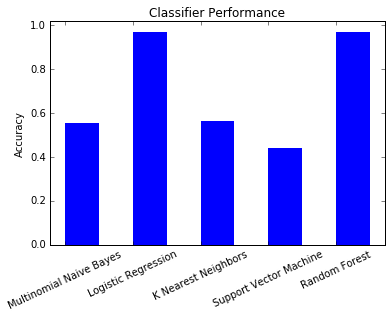

In [10]:
# Visualize classifier performance
x = range(5)
y = [acc_nb, acc_lg, acc_knn, acc_svc, acc_rf]
clf_names = ['Multinomial Naive Bayes', 'Logistic Regression', \
             'K Nearest Neighbors', 'Support Vector Machine', 'Random Forest']

width = 0.6/1.2
plt.bar(x, y, width)

plt.title('Classifier Performance')
plt.xticks(x, clf_names, rotation=25)
plt.ylabel('Accuracy')

## 8. Explain the degree to which you believe the result and why

The best classification accuracy on the test set is 96.8%, yielded by the random forest classifier. Both logistic regression and random forest gave satisfying results on our real data.

In the simulation setting, all classifiers except for Naive Bayes yielded high test accuracy, while on real data, KNN and SVM performed poorly.

Note that for this notebook, we preprocessed features using PCA and Sparse PCA, to eliminate the dimensionality curse for SVM, but its performance is still intolerable. The analysis of the other four classifiers are conducted in Classification.ipynb Step 8, and is also applicable in this setting (reduced features).

Next Steps:
 - Think about our assumptions.
 - Look into the reduced features, try finding out why SVM performed even more poorly.
 - Explore other machine learning techniques.